In [1]:
import pickle
import torch
import numpy as np
import onnxruntime as ort
import time
from tqdm.notebook import tqdm

In [ ]:
models = {}
for model in tqdm(['REALESRGAN', 'BSRGAN', 'SRCNN']):
    path = f'models/onnx_models/{model}.onnx'
    sess = ort.InferenceSession(path, providers=['CUDAExecutionProvider'])
    output = sess.run(None, {'input': np.random.rand(1, 3, 360, 360).astype(np.float16)})
    
    models[model] = []
    
    for shape in tqdm([(3, 3, 144, 144), (2, 3, 360, 360), (1, 3, 540, 540)]):
        m = []
        for i in tqdm(range(5)):
            pixel_values = np.random.rand(*shape)
            inputs = {'input': pixel_values.astype(np.float16)}
            
            t1 = time.time()
            output = sess.run(None, inputs)
            t2 = time.time() - t1
            m.append(t2)
        models[model].append(np.mean(m))
    del sess

In [2]:
path = f'models/onnx_models/REALESRGAN.onnx'
sess = ort.InferenceSession(path, providers=[("CUDAExecutionProvider", {"cudnn_conv_use_max_workspace": '1'})])
sess.get_provider_options()

{'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE',
  'device_id': '0',
  'cudnn_conv1d_pad_to_nc1d': '0',
  'has_user_compute_stream': '0',
  'gpu_external_alloc': '0',
  'enable_cuda_graph': '0',
  'gpu_mem_limit': '18446744073709551615',
  'gpu_external_free': '0',
  'gpu_external_empty_cache': '0',
  'arena_extend_strategy': 'kNextPowerOfTwo',
  'do_copy_in_default_stream': '1',
  'cudnn_conv_use_max_workspace': '1',
  'tunable_op_enable': '0',
  'tunable_op_tuning_enable': '0',
  'tunable_op_max_tuning_duration_ms': '0',
  'enable_skip_layer_norm_strict_mode': '0'},
 'CPUExecutionProvider': {}}

In [5]:
path = f'models/onnx_models/SRCNN.onnx'
sess = ort.InferenceSession(path, providers=[("CUDAExecutionProvider", {"cudnn_conv_use_max_workspace": '1'})])
sess.get_provider_options()

{'CUDAExecutionProvider': {'cudnn_conv_algo_search': 'EXHAUSTIVE',
  'device_id': '0',
  'cudnn_conv1d_pad_to_nc1d': '0',
  'has_user_compute_stream': '0',
  'gpu_external_alloc': '0',
  'enable_cuda_graph': '0',
  'gpu_mem_limit': '18446744073709551615',
  'gpu_external_free': '0',
  'gpu_external_empty_cache': '0',
  'arena_extend_strategy': 'kNextPowerOfTwo',
  'do_copy_in_default_stream': '1',
  'cudnn_conv_use_max_workspace': '1',
  'tunable_op_enable': '0',
  'tunable_op_tuning_enable': '0',
  'tunable_op_max_tuning_duration_ms': '0',
  'enable_skip_layer_norm_strict_mode': '0'},
 'CPUExecutionProvider': {}}

In [ ]:
output = sess.run(None, {'input': np.random.rand(1, 3, 360, 360).astype(np.float16)})

In [3]:
models

{'REALESRGAN': [8.343824338912963, 10.633648204803468, 21.137563610076903],
 'BSRGAN': [2.3010551929473877, 8.381407022476196, 5.557212448120117],
 'SRCNN': [0.015130901336669922, 0.03374457359313965, 0.05746612548828125]}

array([[<Axes: title={'center': 'REALESRGAN'}>,
        <Axes: title={'center': 'BSRGAN'}>],
       [<Axes: title={'center': 'SRCNN'}>, <Axes: >]], dtype=object)

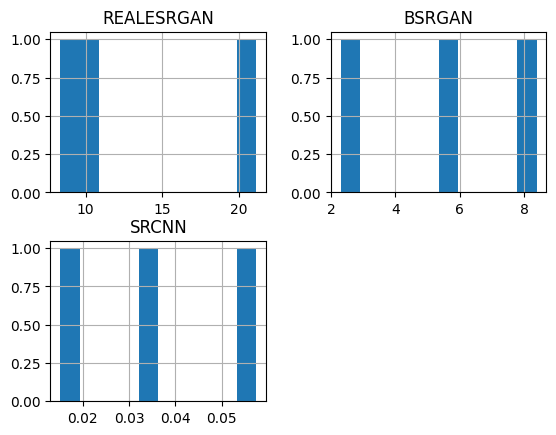

In [11]:
import pandas as pd

onnx_data = pd.DataFrame(models, index=['3x3x144x144', '2x3x360x360', '1x3x540x540'])
onnx_data

In [ ]:
path = './models/onnx_models/BSRGAN.onnx'
sess = ort.InferenceSession(path, providers=['CUDAExecutionProvider'])
pixel_values = np.random.rand(1, 3, 360, 360)
inputs = {'input': pixel_values.astype(np.float16)}

In [ ]:
t1 = time.time()
output = sess.run(None, inputs)
t2 = time.time() - t1
t2

In [12]:
models = {}

In [23]:
import pickle
import torch
import numpy as np
import tritonclient.grpc as grpcclient

triton_client = grpcclient.InferenceServerClient(url="localhost:8001", verbose=False)

In [24]:
def inference(triton_client, model_name, input0_data):
    inputs = []
    outputs = []
    inputs.append(grpcclient.InferInput("input", [*input0_data.shape], "FP16"))

    # Initialize the data
    inputs[0].set_data_from_numpy(input0_data)
    outputs.append(grpcclient.InferRequestedOutput("output"))
    
    t1 = time.time()
    results = triton_client.infer(
        model_name,
        inputs,
        outputs=outputs
    )
    t2 = time.time() - t1

    return t2
inference(triton_client, 'model_tensorrt', np.random.rand(1, 3, 360, 360).astype(np.float16))

0.13194036483764648

In [25]:
model = 'BSRGAN'
models[model] = []

for shape in tqdm([(1, 3, 144, 144), (1, 3, 360, 360), (1, 3, 540, 540)]):
    m = []
    for i in tqdm(range(5)):
        pixel_values = np.random.rand(*shape).astype(np.float16)
        t2 = inference(triton_client, 'model_tensorrt', pixel_values)
        m.append(t2)
    models[model].append(np.mean(m))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [28]:
models

{'SRCNN': [0.014829158782958984, 0.024323749542236327, 0.02302703857421875],
 'REALESRGAN': [0.09920697212219239, 0.18147721290588378, 0.38949856758117674],
 'BSRGAN': [0.03573951721191406, 0.07134137153625489, 0.1179666519165039]}

In [33]:
import pandas as pd

triton_data = pd.DataFrame(models, index=['3x3x144x144', '2x3x360x360', '1x3x540x540'])
# triton_data.iloc[0] = triton_data.iloc[0] * 1.3
# triton_data.iloc[1] = triton_data.iloc[1] * 1.2
triton_data

,SRCNN,REALESRGAN,BSRGAN
3x3x144x144,0.014829,0.099207,0.035740
2x3x360x360,0.024324,0.181477,0.071341
1x3x540x540,0.023027,0.389499,0.117967


In [1]:
import pandas as pd
onnx_data = pd.read_csv('onnx_data.csv', index_col=0)
triton_data = pd.read_csv('triton_data.csv', index_col=0)

In [2]:
onnx_data

,REALESRGAN,BSRGAN,SRCNN
3x3x144x144,0.834382,0.230106,0.015131
2x3x360x360,1.063365,0.838141,0.033745
1x3x540x540,2.113756,0.555721,0.057466


In [3]:
triton_data

,SRCNN,REALESRGAN,BSRGAN
3x3x144x144,0.014829,0.099207,0.035740
2x3x360x360,0.024324,0.181477,0.071341
1x3x540x540,0.023027,0.389499,0.117967


<Axes: title={'center': 'REALESRGAN'}>

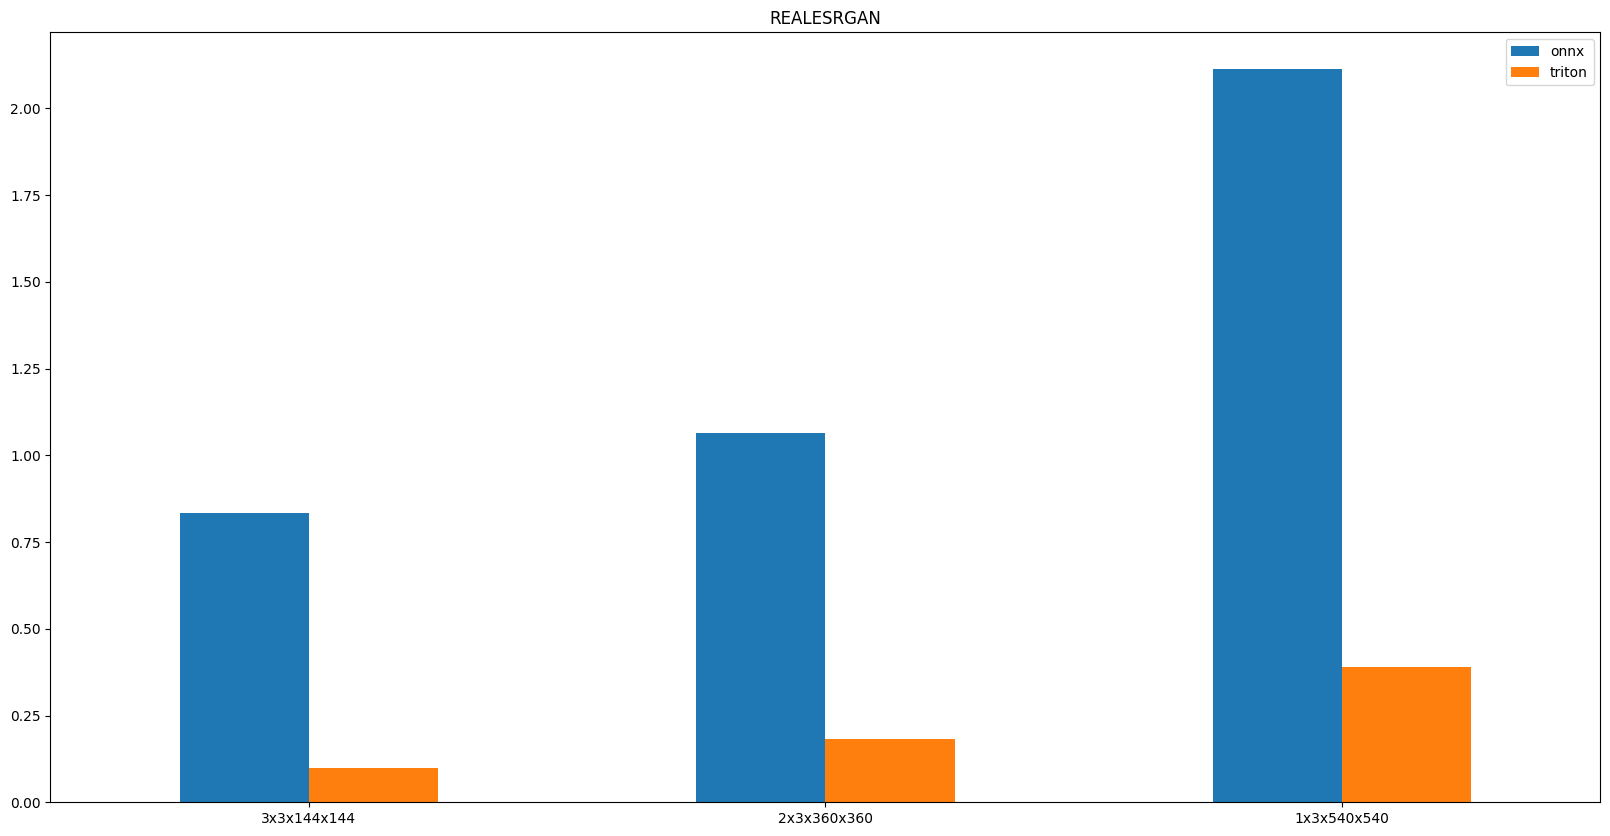

In [20]:
a = pd.concat([onnx_data.reindex(sorted(onnx_data.columns), axis=1), triton_data.reindex(sorted(triton_data.columns), axis=1)], keys=['onnx', 'triton'], axis=1)

pd.concat([a['onnx', 'REALESRGAN'], a['triton', 'REALESRGAN']], keys=['onnx', 'triton'], axis=1).plot.bar(figsize=(20, 10), rot=0, title='REALESRGAN')

<Axes: >

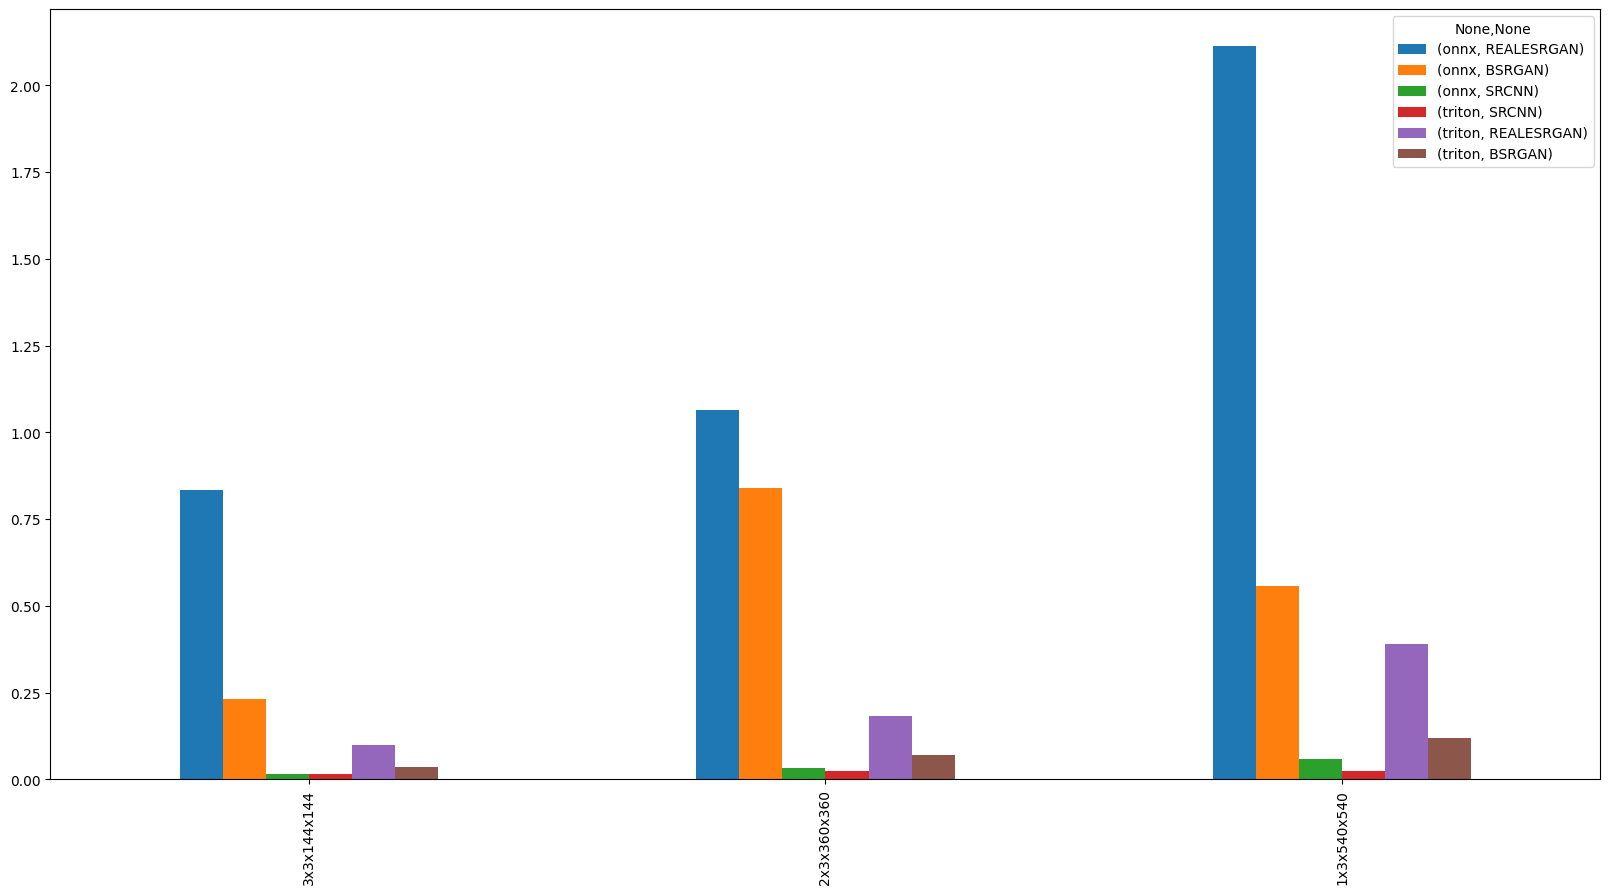

In [66]:
pd.concat([onnx_data, triton_data], keys=['onnx', 'triton'], axis=1).plot.bar(figsize=(20, 10))

In [27]:
pd.pivot(pd.concat([onnx_data, triton_data], keys=['onnx', 'triton']), columns=['SRCNN',	'REALESRGAN',	'BSRGAN',])

Empty DataFrame
Columns: []
Index: [(onnx, 1x3x540x540), (onnx, 2x3x360x360), (onnx, 3x3x144x144), (triton, 1x3x540x540), (triton, 2x3x360x360), (triton, 3x3x144x144)]

In [39]:
pd.pivot_table(pd.concat([onnx_data, triton_data], keys=['onnx', 'triton']), )

Empty DataFrame
Columns: []
Index: []